In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

In [2]:
train_ds = pd.read_csv("./Data/train.csv")
test_ds = pd.read_csv("./Data/test.csv")

In [3]:
print(train_ds.shape)
print(test_ds.shape)

(42000, 785)
(28000, 784)


In [66]:
X_train = train_ds.iloc[:, 1:].values.astype('float32')
y_train = train_ds.iloc[:, 0].values.astype('int32')

In [201]:
X_test = test_ds.values.astype('float32')

In [67]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)

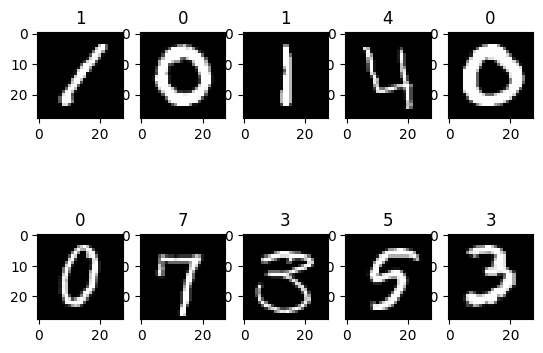

In [68]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap=plt.get_cmap("gray"))
    plt.title(y_train[i])

In [69]:
X_train = np.expand_dims(X_train, axis=1) # Add an extra dimension for the gray scale
# x.swapaxes(2, 3).swapaxes(1, 2)

In [70]:
X_train.shape

(42000, 1, 28, 28)

In [71]:
x_mean = X_train.mean().astype(np.float32)
x_std = X_train.std().astype(np.float32)

In [72]:
def standardize(x):
    return (x-x_mean) / x_std

def to_categorical(y, num_labels): # one hot vector
    return np.eye(num_labels)[y]

In [73]:
seed = 45
np.random.seed(seed)

In [74]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input_layer = self.Lambda(standardize)
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(28, 32, kernel_size=3),
            self.relu,
            self.pool,
        )
         
        self.linear = nn.Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2_block(x)
        x = x.view(x.size(0), -1)
        return self.linear(x)
        
    class Lambda(nn.Module):
        def __init__(self, lambd):
            super().__init__()
            self.lambd = lambd
        def forward(self, x):
            return torch.tensor(self.lambd(x))

In [75]:
model = Model()

In [15]:
pred = model(X_train)

In [76]:
# t = model(np.expand_dims(X_train[0], 0))
# plt.imshow(t.detach()[0, :, :], cmap="gray")

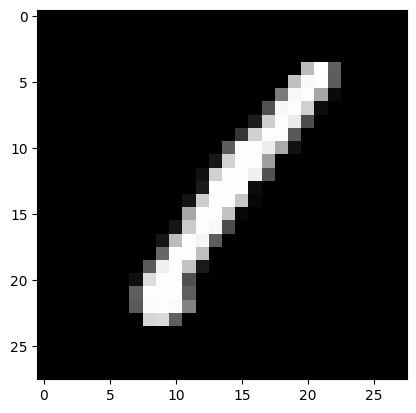

In [77]:
plt.imshow(X_train[0, 0, :, :], cmap="gray")

In [78]:
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [79]:
print(model)

Model(
  (input_layer): Lambda()
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_block): Sequential(
    (0): Conv2d(28, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=800, out_features=10, bias=True)
)


In [86]:
y_train = to_categorical(y_train, 10)

In [166]:
def train_nn(epochs, net : torch.nn.Module, X_train, y_train):
    
    net.train()
    
    batch_size = 42
    
    epoch_count, train_loss_vals = [], []
    
    X_train = torch.tensor(X_train).split(batch_size)
    y_train = torch.tensor(y_train).split(batch_size)
    
    for epoch in range(epochs):
        for x_batch, y_batch in zip(X_train, y_train):
            y_pred = net(x_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_vals.append(loss)
        print(f"Epoch {epoch}: Train loss of {loss}")
        # print(net.state_dict())
            
    return net, epoch_count, train_loss_vals

In [167]:
trained_model, epoch_count, train_loss_vals = train_nn(10, model, X_train, y_train)

C:\Users\Josemaria\AppData\Local\Temp\ipykernel_14568\2283935433.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.lambd(x))


Epoch 0: Train loss of 0.008753881229151227
Epoch 1: Train loss of 6.633095957940869e-05
Epoch 2: Train loss of 0.03415236266499767
Epoch 3: Train loss of 0.004020946458121259
Epoch 4: Train loss of 1.308171649887819e-05
Epoch 5: Train loss of 3.0348134802388976e-05
Epoch 6: Train loss of 0.013337727210302236
Epoch 7: Train loss of 1.4762803023889623e-05
Epoch 8: Train loss of 2.8099165796274544e-07
Epoch 9: Train loss of 2.838316248698902e-09


In [169]:
n_pred = trained_model(X_train)

In [191]:
_, idx = n_pred.max(1)
idx.shape

torch.Size([42000])

In [192]:
train_pred = to_categorical(idx, 10)

In [ ]:
# X_test now

In [205]:
X_test = X_test.reshape(X_test.shape[0], 28, 28)

In [208]:
X_test = np.expand_dims(X_test, axis=1) # Add gray scale channel

In [210]:
trained_model.eval()
with torch.inference_mode():
    t_pred = trained_model(X_test)

In [214]:
_, idx = t_pred.max(1)
idx.shape
test_pred = to_categorical(idx, 10)

In [215]:
test_pred

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])